Get training data

In [1]:
!git clone https://github.com/caixunshiren/alpaca_bot.git
! pip install alpaca-trade-api

Cloning into 'alpaca_bot'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 145 (delta 56), reused 120 (delta 31), pack-reused 0
Receiving objects: 100% (145/145), 1004.55 KiB | 13.22 MiB/s, done.
Resolving deltas: 100% (56/56), done.
     |████████████████████████████████| 40 kB 3.4 MB/s 
     |████████████████████████████████| 103 kB 7.3 MB/s 
     |████████████████████████████████| 68 kB 4.7 MB/s 


In [2]:

from alpaca_bot.scripts.apimanagers import APImanager
from alpaca_bot.scripts.assets import Account, Stock
from alpaca_bot.scripts.botmanagers import Stocks_manager_naive
#from alpaca_bot.scripts.bots import Moving_average_bot, Macd_bot

import numpy as np
import pandas as pd
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame
import datetime
import time

In [3]:
# global variables
API_KEY = "PKW4QJCBVY9V19D2ACFX"#<your API_KEY here>
SECRET_KEY = "Qn660Zot3VSUOFFUd8RhbitHkZdnSrcAZqudzItj"#<your SECRET_KEY here>
CUR_TIME_DELAYED = (datetime.datetime.now(datetime.timezone.utc) - datetime.timedelta(minutes=16))  # 16 minutes delay of current time for bars data
CUR_TIME = (datetime.datetime.now(datetime.timezone.utc))  # 15 minutes delay of current time for bars data
print(CUR_TIME_DELAYED)

2021-07-26 13:58:59.274095+00:00


In [4]:
API_manager = APImanager(API_KEY, SECRET_KEY)

In [52]:
hour_bar_apple, hour_bar_apple_t = API_manager.get_bar("AAPL", TimeFrame.Hour, "2020-08-29", "2021-07-17")
cur_price_apple = API_manager.get_price("AAPL")

In [53]:
print(len(hour_bar_apple))
print(hour_bar_apple_t[0])

3532
2021-07-16 23:00:00+00:00


In [54]:
APPL_hour = Stock("AAPL", cur_price_apple, CUR_TIME_DELAYED, hour_bar_apple, TimeFrame.Hour, hour_bar_apple_t[0])

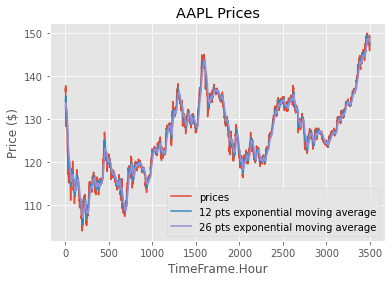

In [55]:
# plot price
APPL_hour.plot_price(3500)

In [56]:
import matplotlib.pyplot as plt
def plot_price(prices, title = ""):
      plt.style.use('ggplot')
      plt.clf()
      plt.plot(range(prices.size), prices, label = "prices")
      plt.title(title)
      plt.legend()
      plt.xlabel("Hour")
      plt.ylabel("Price ($)")  
      plt.show()

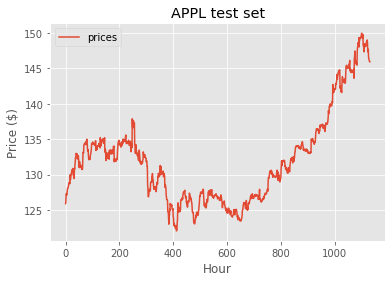

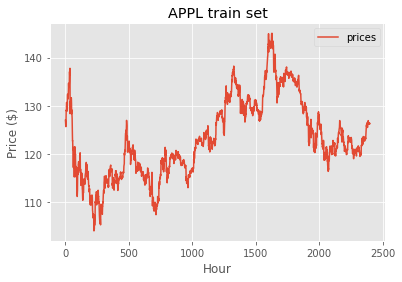

In [57]:
hour_bar = hour_bar_apple[::-1]#reverse the order of hour-bar from earlist to latest
train_set = np.array(hour_bar[:2400])
test_set = np.array(hour_bar[2400:])
plot_price(test_set, "APPL test set")
plot_price(train_set, "APPL train set")

Data Preprocessing

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import copy

In [59]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

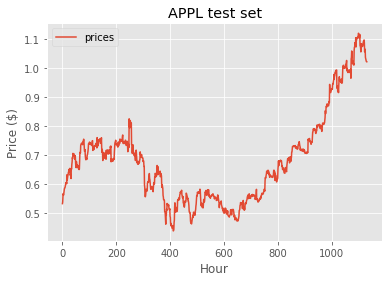

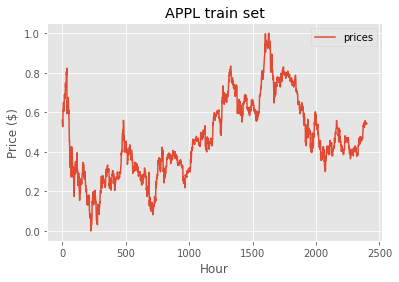

In [60]:
train_scaled = scaler.fit_transform(train_set.reshape(-1, 1))
test_scaled = scaler.transform(test_set.reshape(-1, 1))
plot_price(test_scaled, "APPL test set")
plot_price(train_scaled, "APPL train set")

In [61]:
#we use first n_past data points to predict the next n_predict data points
n_past = 80
n_predict = 1
def create_batches(data, n_past, n_predict):
    N = data.shape[0]
    batches = np.zeros([N-(n_past + n_predict), n_past + n_predict])
    for i in range(N - (n_past + n_predict)):
        batches[i, :] = np.squeeze(data[i:i+(n_past + n_predict)])
    return torch.from_numpy(batches[:, :n_past]).float() , torch.from_numpy(batches[:, n_past:]).float()

train_X, train_Y = create_batches(train_scaled, n_past, n_predict)
test_X, test_Y = create_batches(test_scaled, n_past, n_predict)
print("train set:", train_X.shape, train_Y.shape)
print("test set:", test_X.shape, test_Y.shape)

train set: torch.Size([2319, 80]) torch.Size([2319, 1])
test set: torch.Size([1051, 80]) torch.Size([1051, 1])


LSTM model

In [64]:
# Here we define our model
in_dim = 1
out_dim = 1
hidden_dim = 64
epoch = 500
lr = 0.01

class LSTM(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim, activation_o = None):
        super(LSTM, self).__init__()
        self.num_layers = 1
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_dim = hidden_dim    
        self.lstm = nn.LSTM(in_dim, hidden_dim, 1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, out_dim)
        if activation_o is not None:
          self.activation_o = activation_o
        else:
          self.activation_o = None

    def get_next_predict(self, input, hn, cn):
        input = input.view(input.shape[0], input.shape[1],1)
        #print(input.shape, hn.shape, cn.shape)
        out, (hn, cn) = self.lstm(input, (hn, cn))
        out = self.fc(out[:, -1, :]) if self.activation_o is None else self.activation_o(self.fc(out[:, -1, :]))
        return out, hn, cn

    def forward(self, x, pred_pts = 5):
        #x in the form (batchsize,sequence length,input dimension)
        #output in the form (batchsize,sequence length,hidden dimension)
        #initialize hidden states to 0
        #print(self.num_layers, x.shape[0], self.hidden_dim)
        h = torch.zeros([self.num_layers, x.shape[0], self.hidden_dim])#.requires_grad()
        c = torch.zeros([self.num_layers, x.shape[0], self.hidden_dim])#.requires_grad()
        #predict next 5 points
        predictions = torch.zeros([x.shape[0], pred_pts])
        for i in range(pred_pts):
            x, h, c = self.get_next_predict(x, h, c)
            predictions[:,i] = torch.squeeze(x)
        return predictions


In [65]:
model = LSTM(in_dim=in_dim, out_dim=out_dim, hidden_dim=hidden_dim)

criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [66]:
log = np.zeros([epoch, 2]) #loss
for t in range(epoch):
    train_pred = model(train_X, pred_pts=n_predict)
    train_loss = criterion(train_pred, train_Y)
    log[t, 0] = train_loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    train_loss.backward()

    # Update parameters
    optimizer.step()

    # Validation set
    model.eval()
    test_pred = model(test_X, pred_pts=n_predict)
    test_loss = criterion(test_pred, test_Y)
    log[t, 1] = test_loss.item()
                
    #print log
    print("Epoch ", t, "MSE train: ", train_loss.item(), "MSE test: ", test_loss.item())

Epoch  0 MSE train:  0.2585643231868744 MSE test:  0.3148152828216553
Epoch  1 MSE train:  0.14116117358207703 MSE test:  0.16531677544116974
Epoch  2 MSE train:  0.06357388198375702 MSE test:  0.029817910864949226
Epoch  3 MSE train:  0.034825414419174194 MSE test:  0.015838120132684708
Epoch  4 MSE train:  0.054431620985269547 MSE test:  0.03572718799114227
Epoch  5 MSE train:  0.029927324503660202 MSE test:  0.06644604355096817
Epoch  6 MSE train:  0.02988620288670063 MSE test:  0.08609884232282639
Epoch  7 MSE train:  0.03407437354326248 MSE test:  0.09233267605304718
Epoch  8 MSE train:  0.03570496290922165 MSE test:  0.08762244135141373
Epoch  9 MSE train:  0.03406240791082382 MSE test:  0.07511147111654282
Epoch  10 MSE train:  0.030213363468647003 MSE test:  0.05804917588829994
Epoch  11 MSE train:  0.025831248611211777 MSE test:  0.040029868483543396
Epoch  12 MSE train:  0.02280682884156704 MSE test:  0.025016387924551964
Epoch  13 MSE train:  0.022554408758878708 MSE test:  

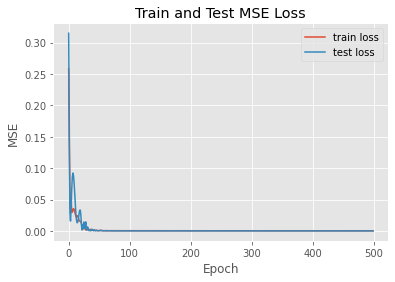

In [67]:
#graph losses
plt.style.use('ggplot')
plt.clf()
plt.plot(range(epoch), log[:, 0], label = "train loss")
plt.plot(range(epoch), log[:, 1], label = "test loss")
plt.title("Train and Test MSE Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE")  
plt.show()

Predictions

In [68]:
model.eval
test_pred = model(test_X, pred_pts=n_predict).detach().numpy()
print(test_pred.shape)
#x_labels and y_labels
x_labels = np.zeros([test_X.shape[0], test_X.shape[1]])
y_labels = np.zeros([test_pred.shape[0], test_pred.shape[1]])
for i in range(test_pred.shape[0]):
    x_labels[i, :] = range(i, i+n_past)
    y_labels[i, :] = range(n_past+i, n_past+i+n_predict)
#print(x_labels)

(1051, 1)


<Figure size 432x288 with 0 Axes>

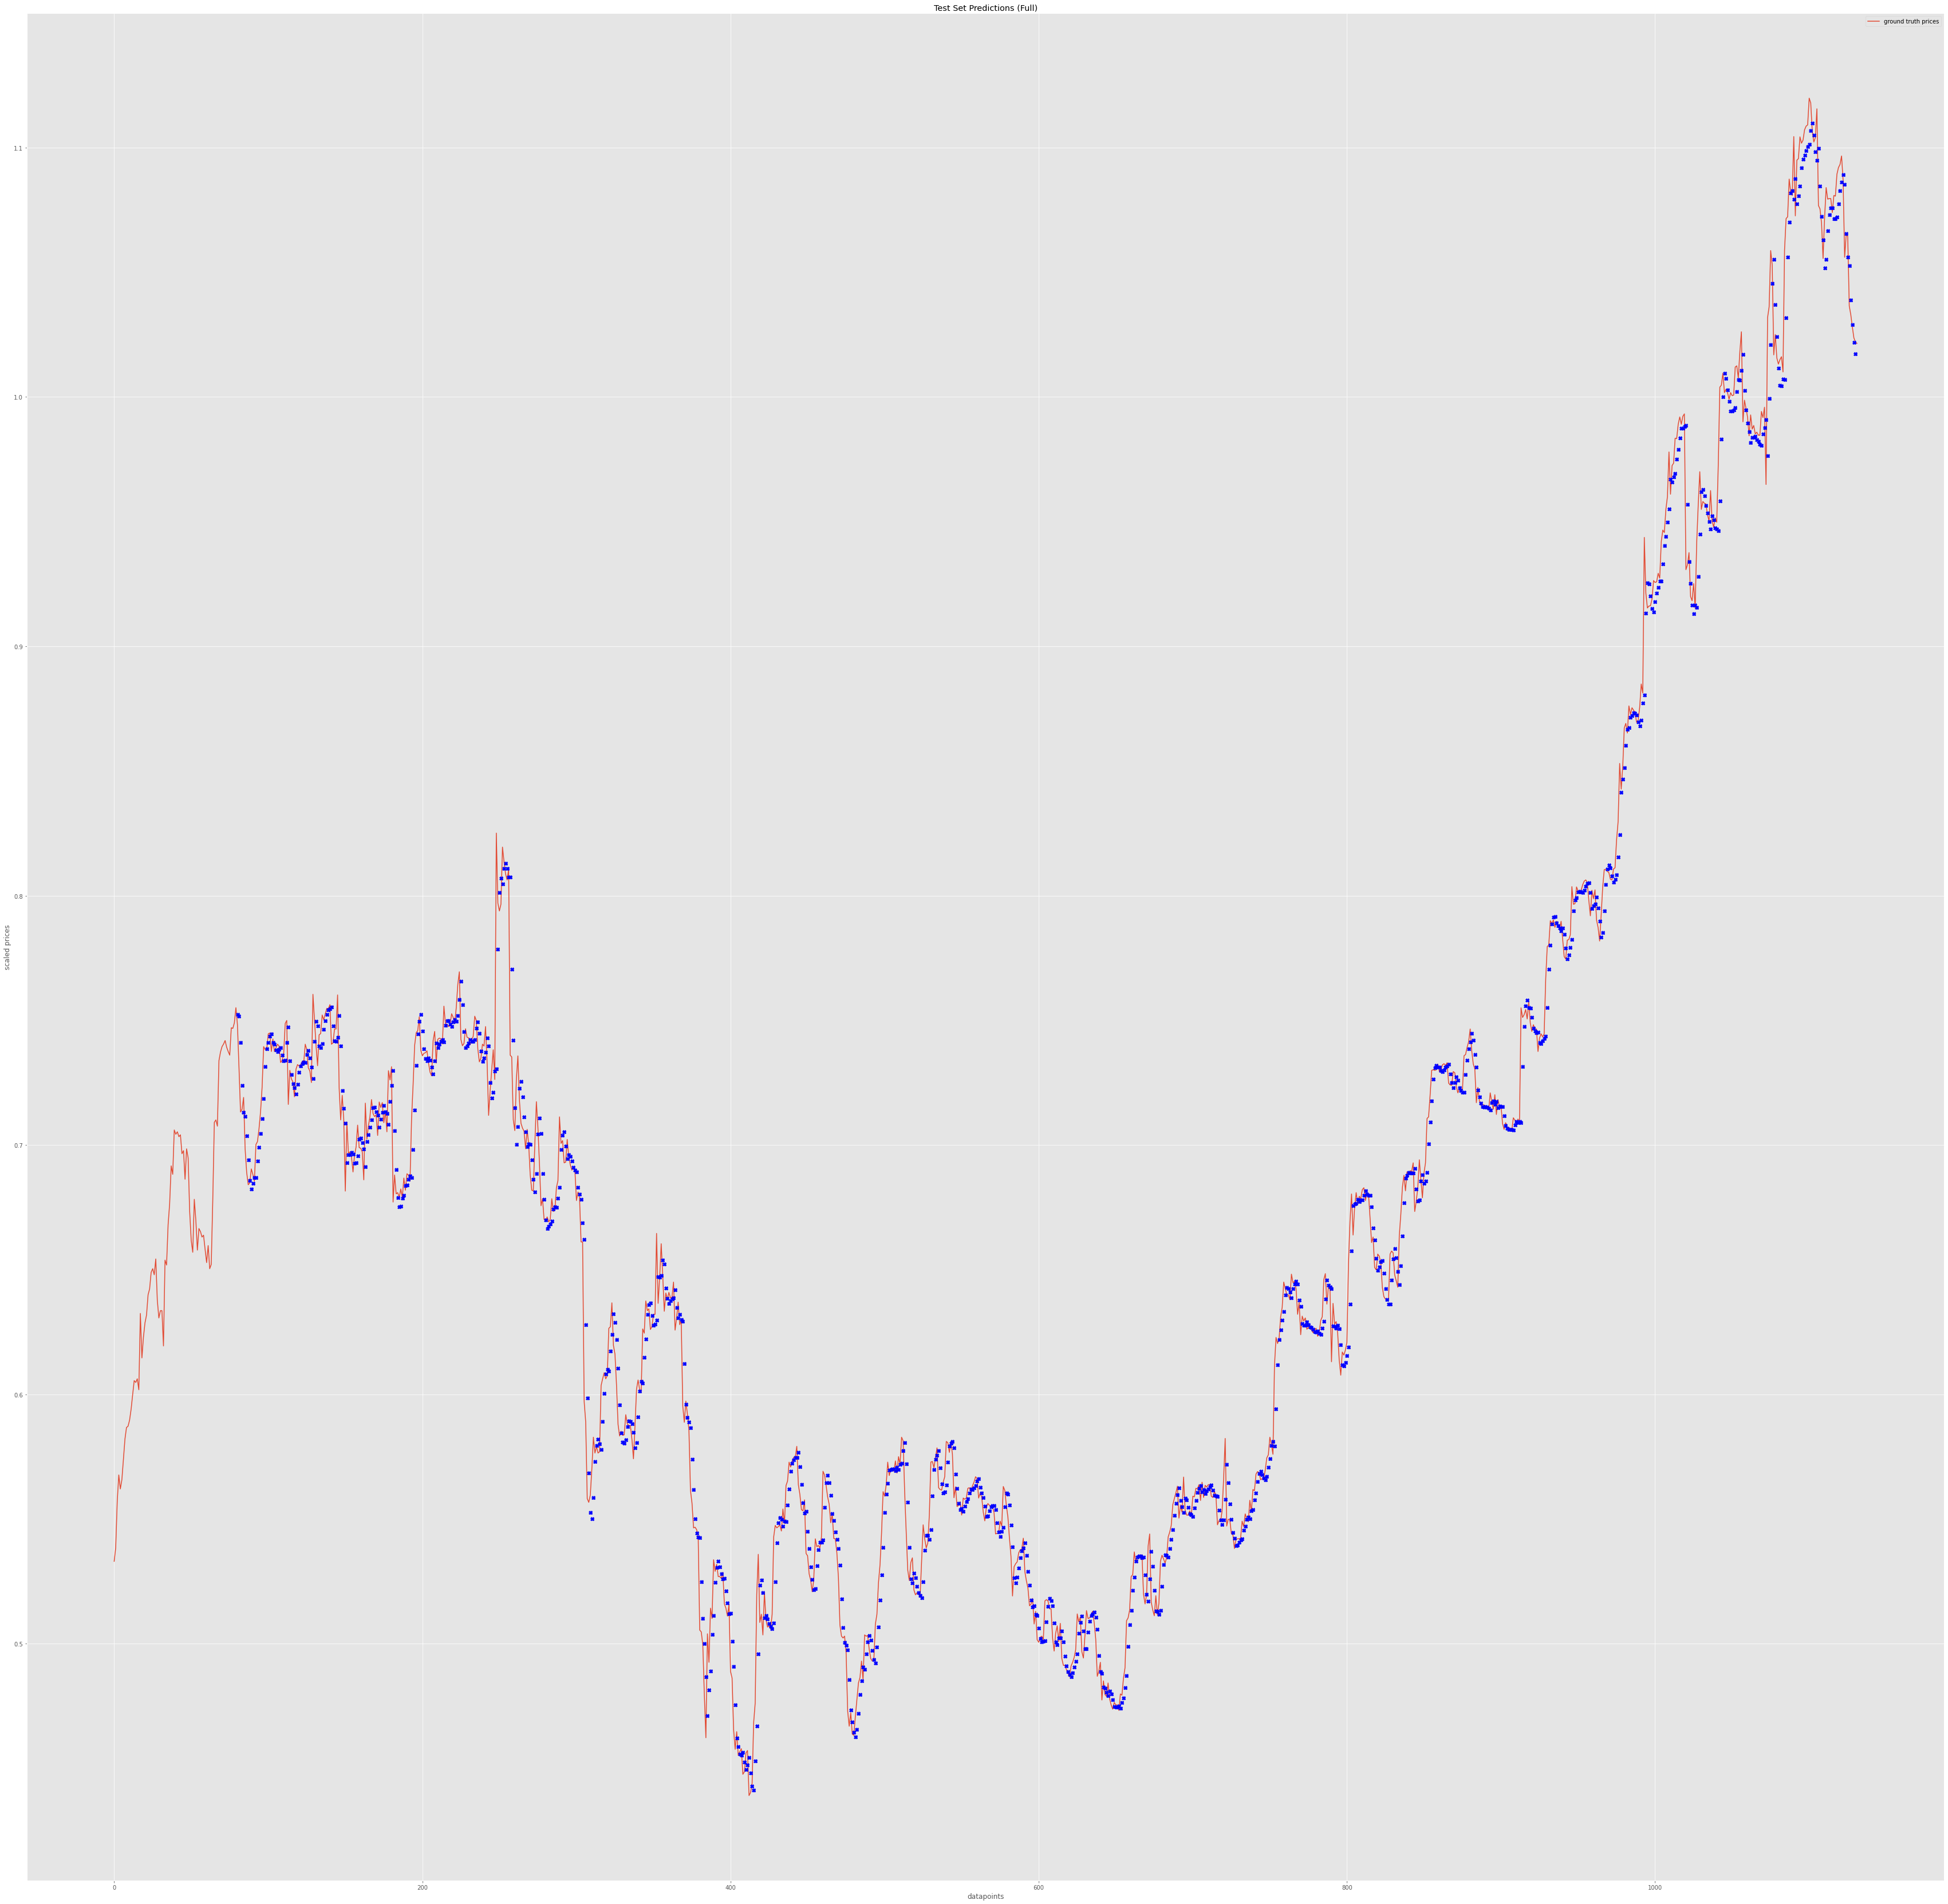

In [69]:
#graph predictions
plt.style.use('ggplot')
plt.clf()
plt.figure(figsize=(60, 60))
plt.plot(range(test_scaled.shape[0]), test_scaled, label = "ground truth prices")
#print predictions
for i in range(test_pred.shape[0]):
    plt.plot(y_labels[i, :], test_pred[i, :], 'X',color = "blue")
plt.title("Test Set Predictions (Full)")
plt.legend()
plt.xlabel("datapoints")
plt.ylabel("scaled prices")  
plt.show()

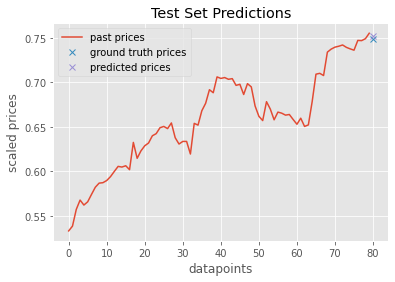

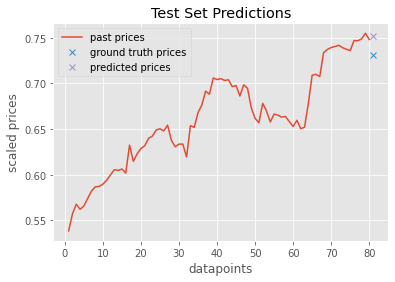

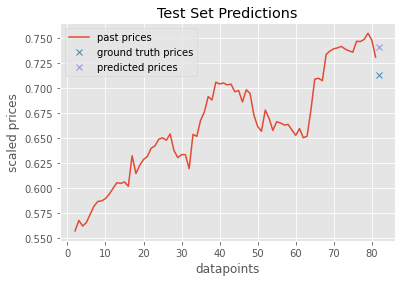

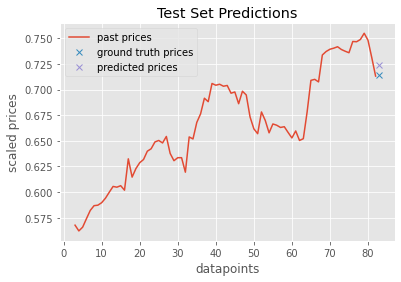

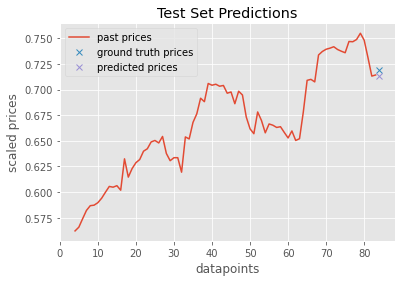

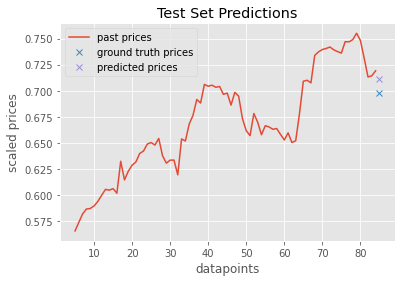

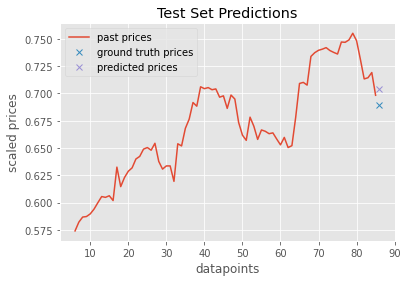

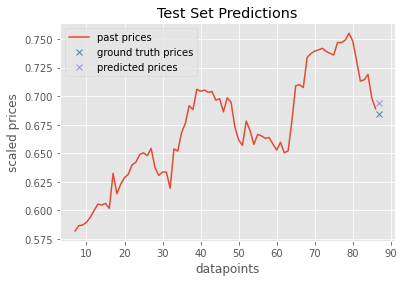

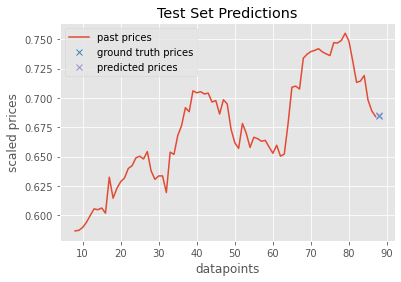

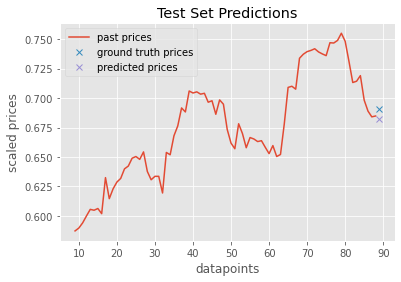

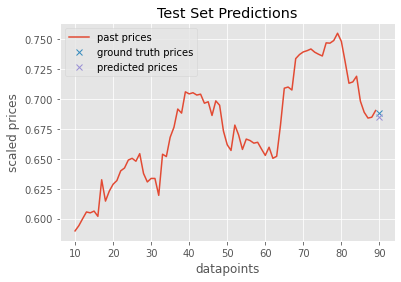

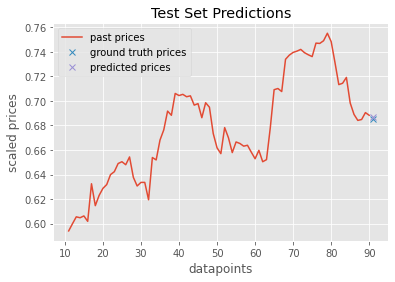

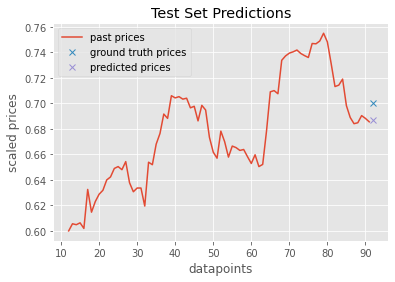

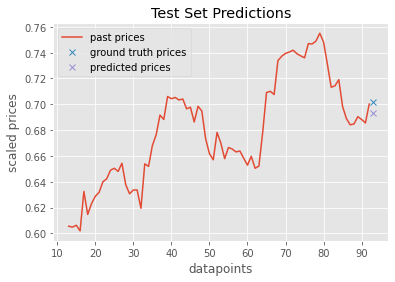

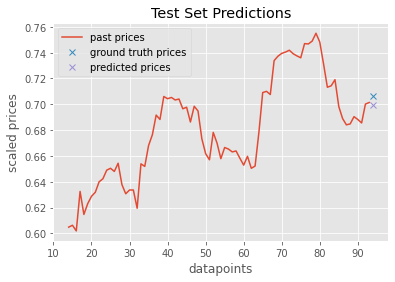

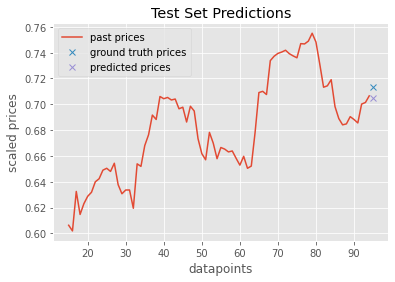

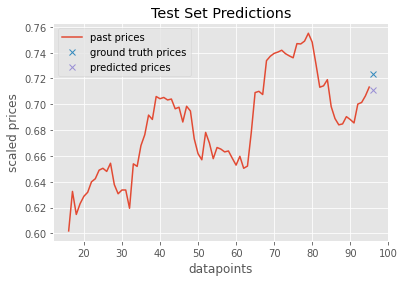

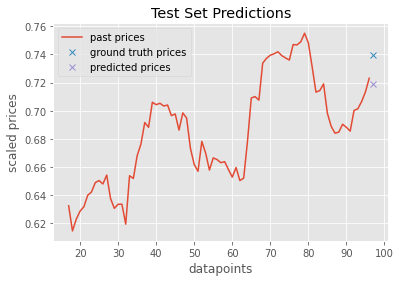

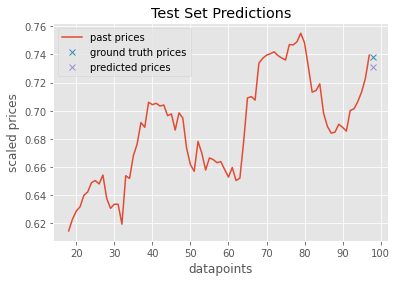

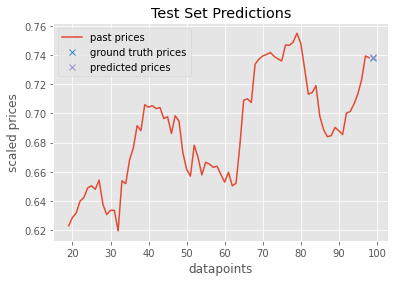

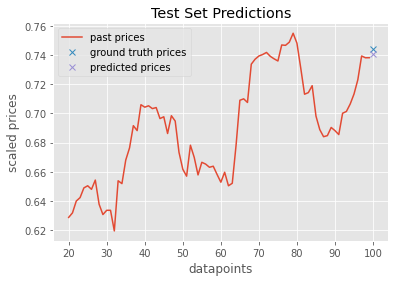

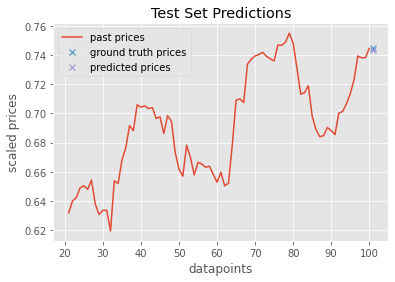

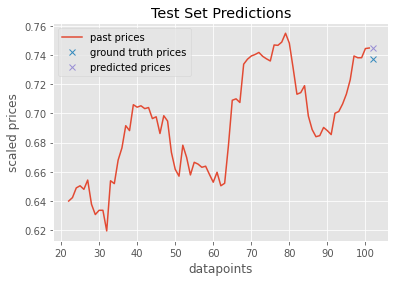

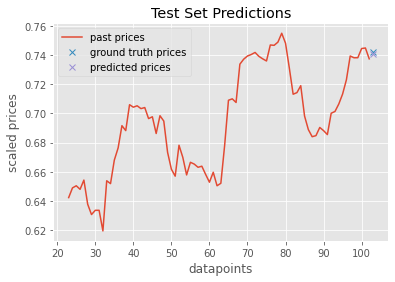

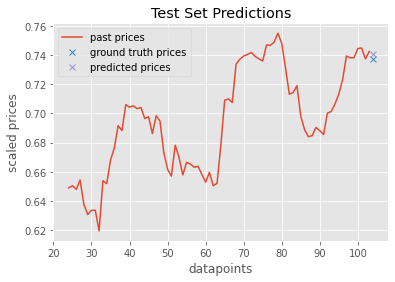

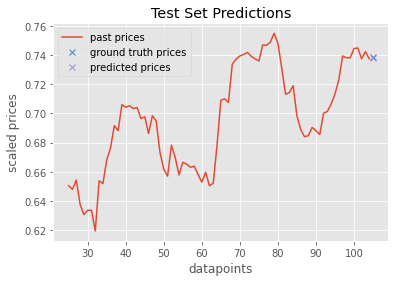

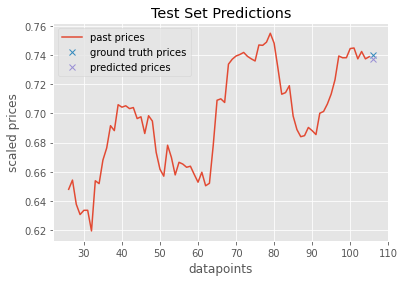

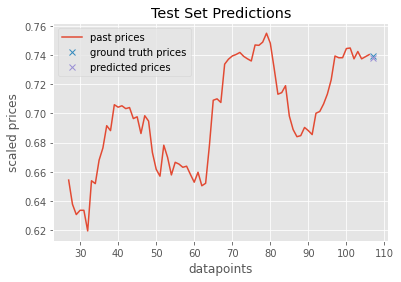

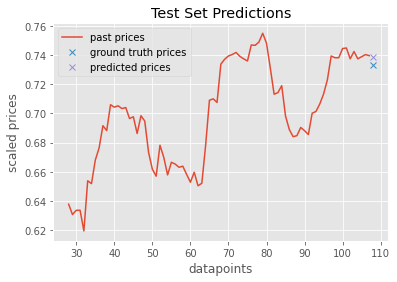

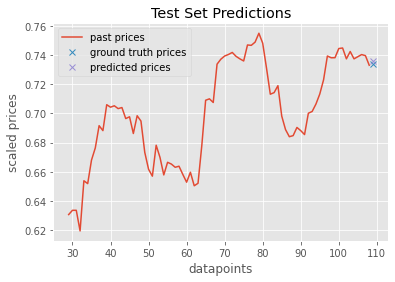

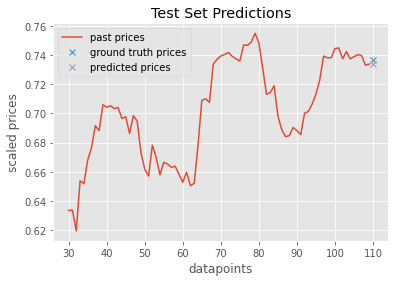

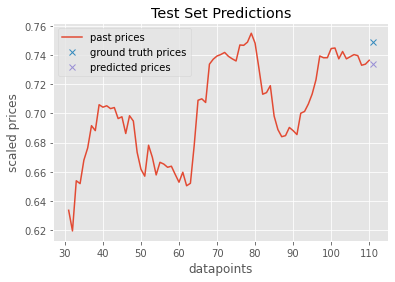

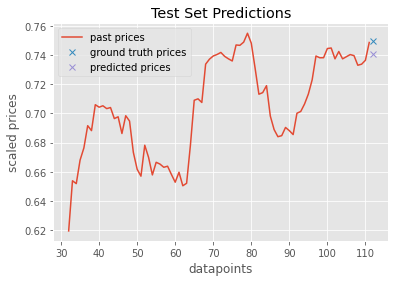

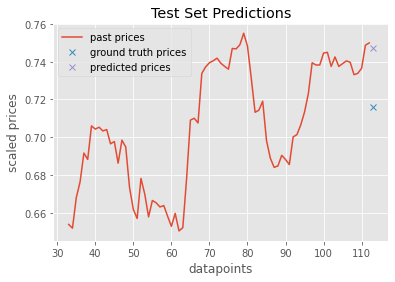

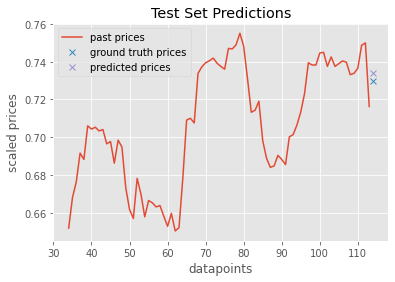

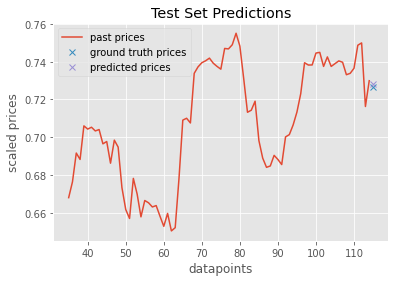

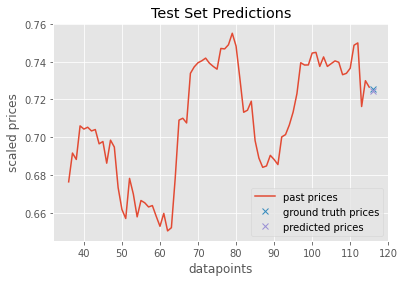

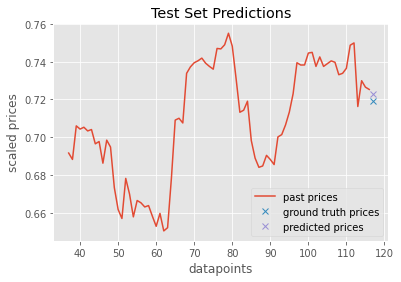

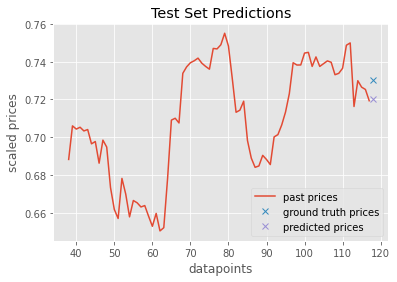

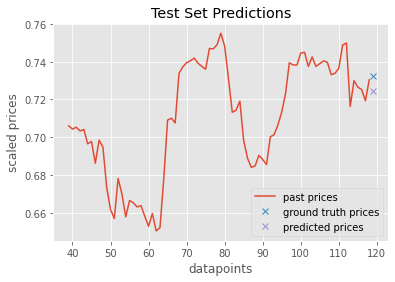

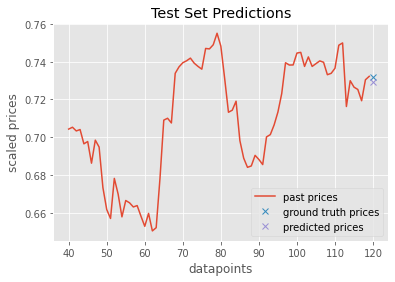

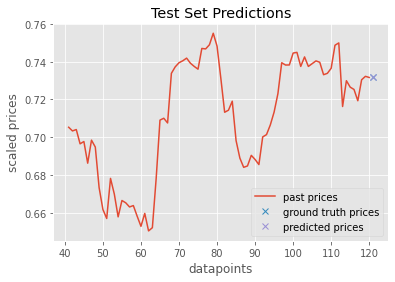

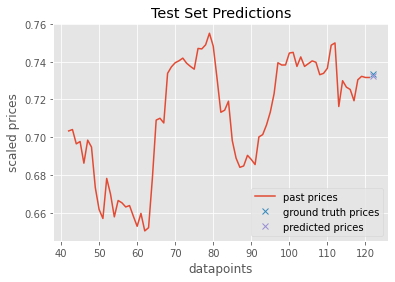

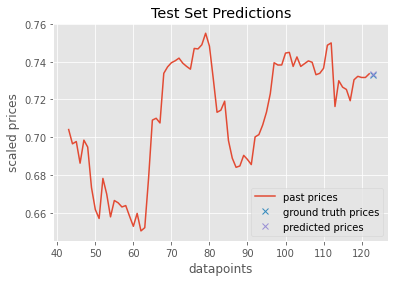

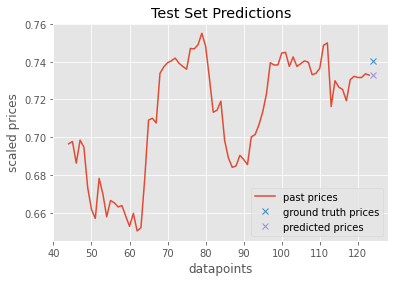

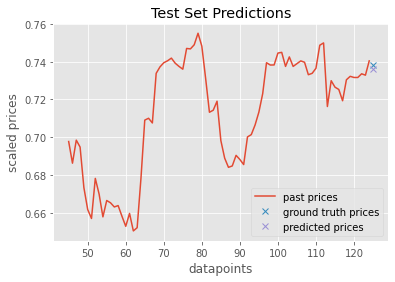

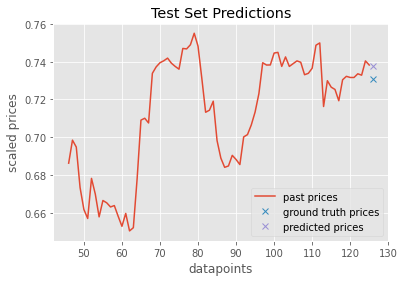

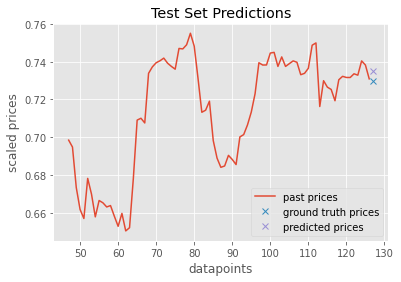

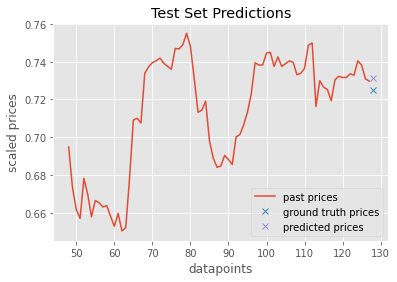

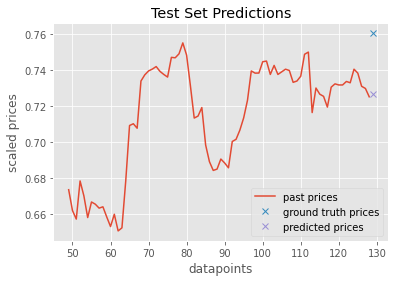

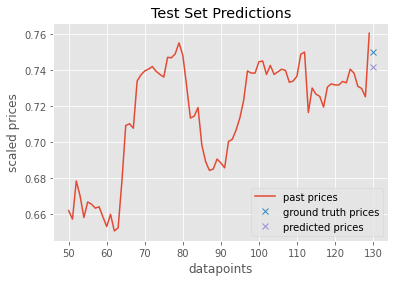

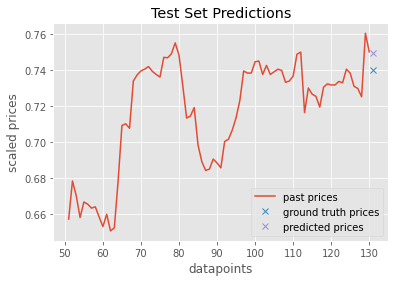

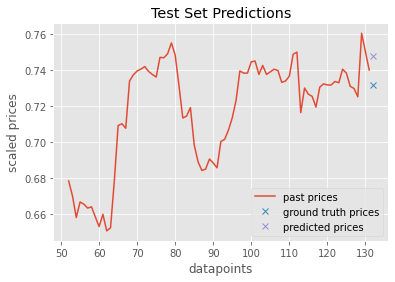

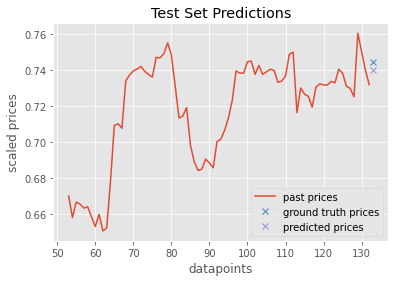

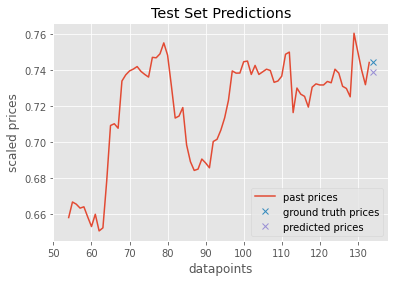

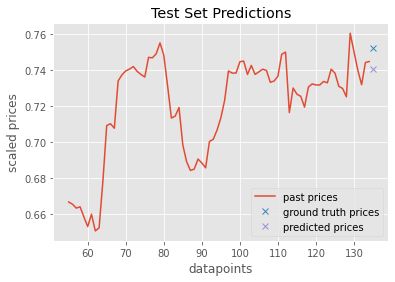

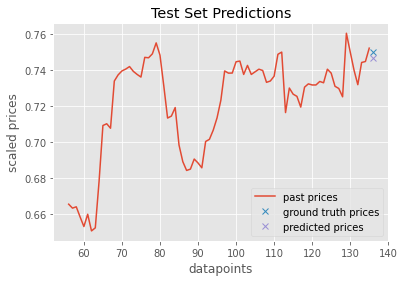

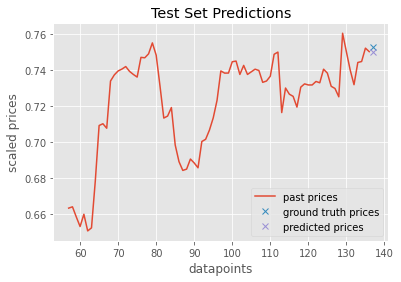

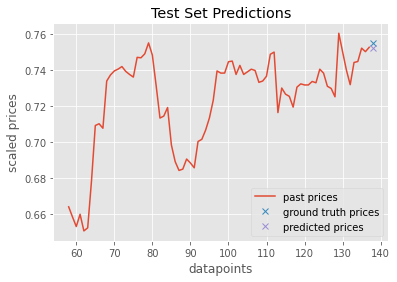

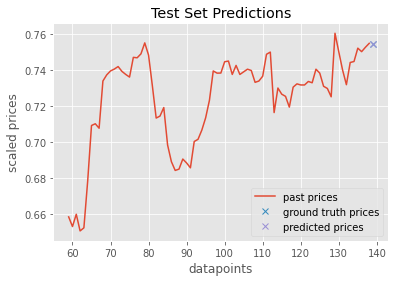

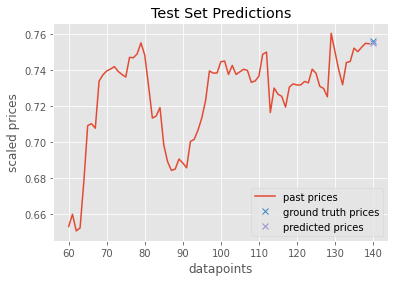

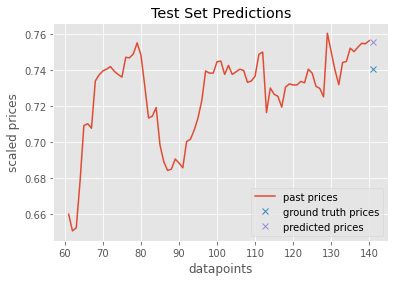

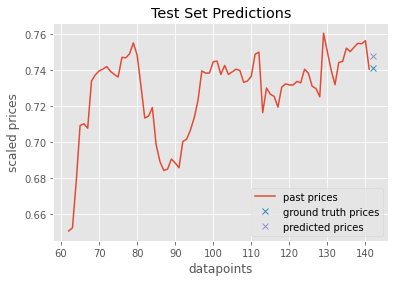

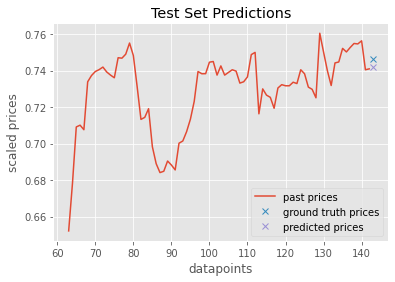

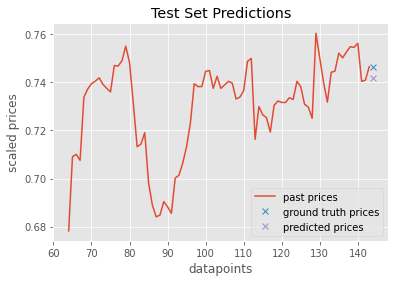

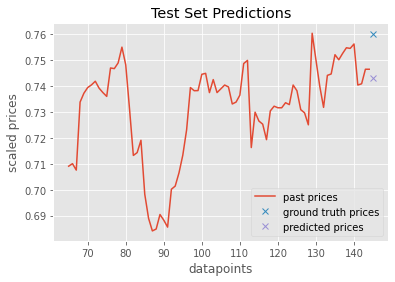

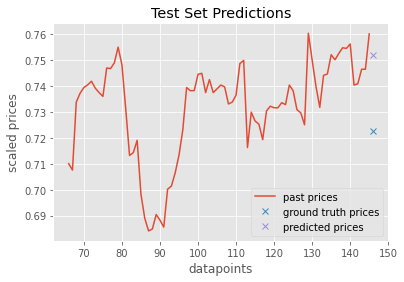

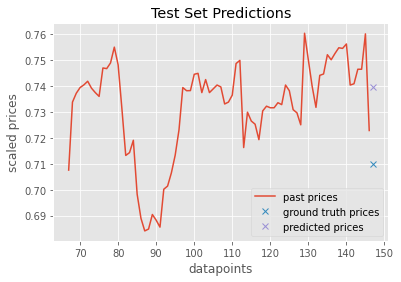

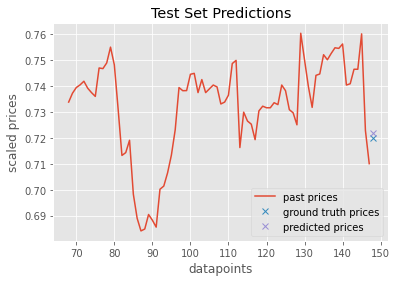

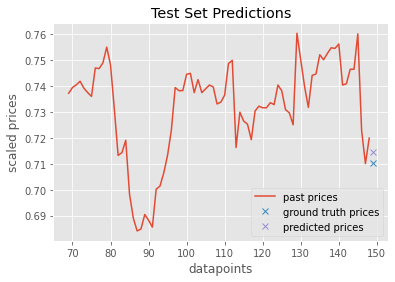

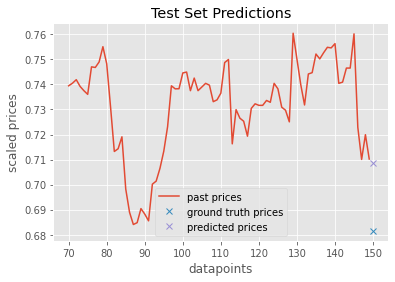

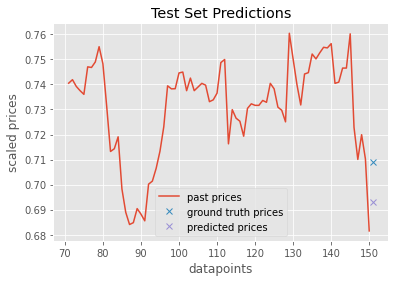

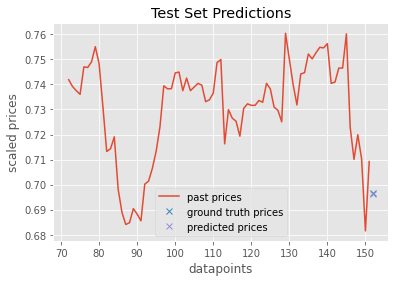

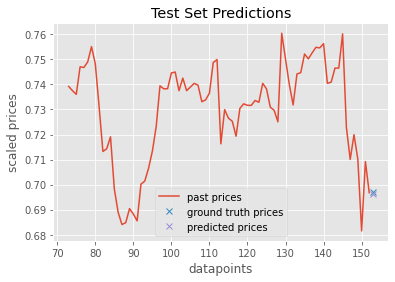

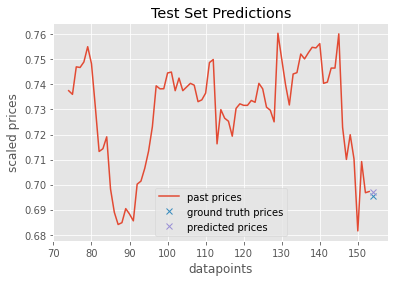

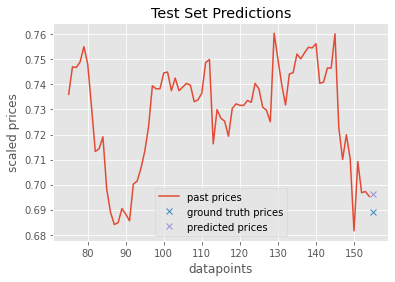

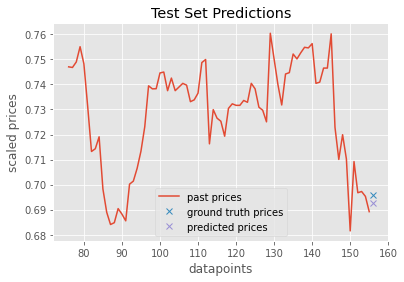

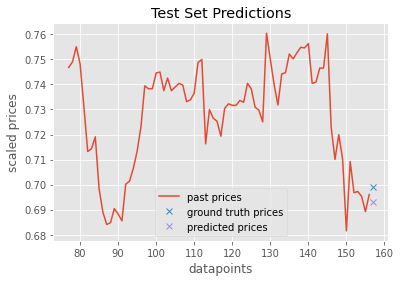

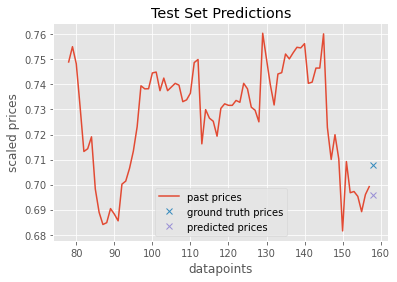

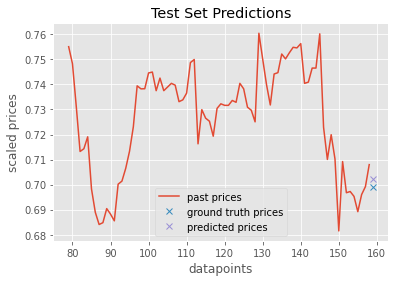

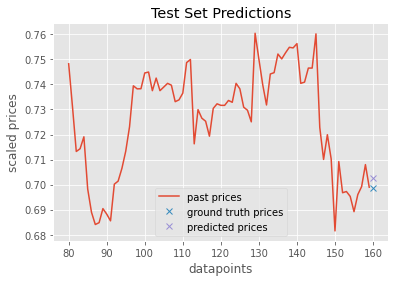

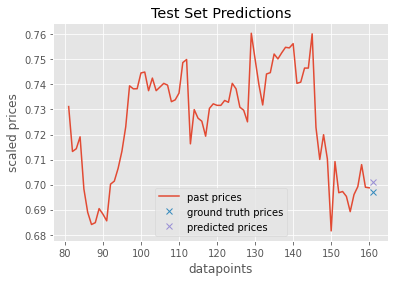

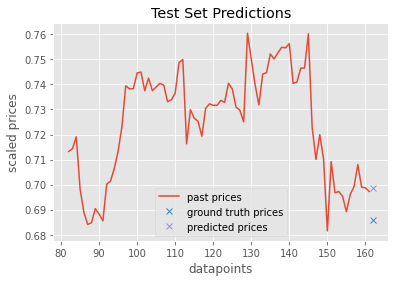

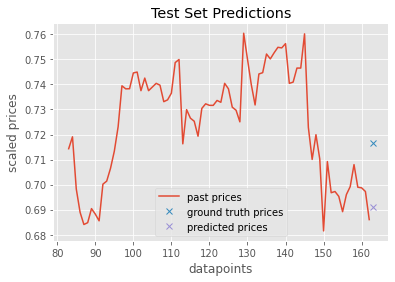

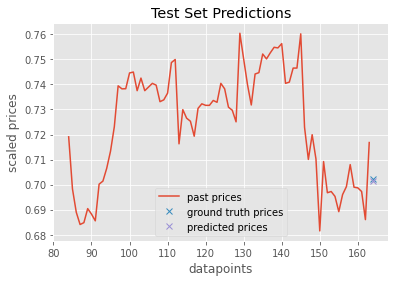

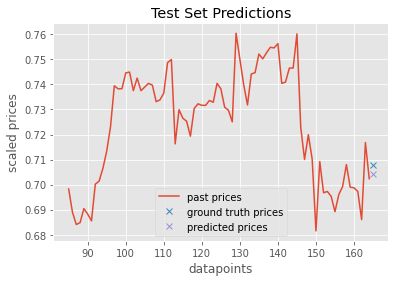

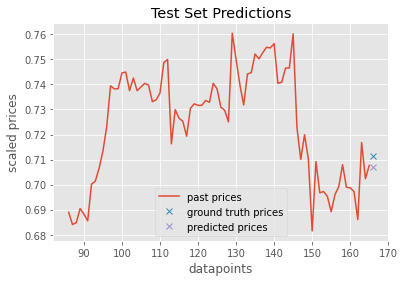

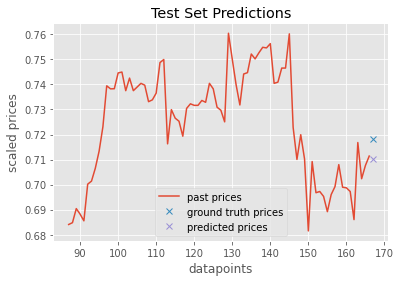

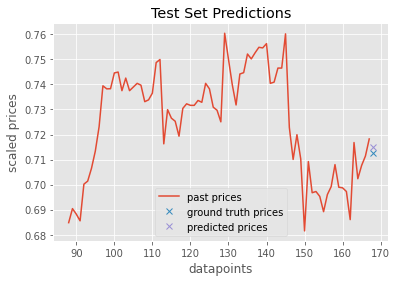

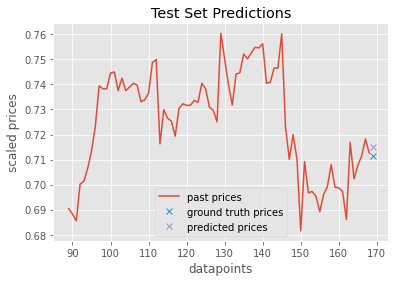

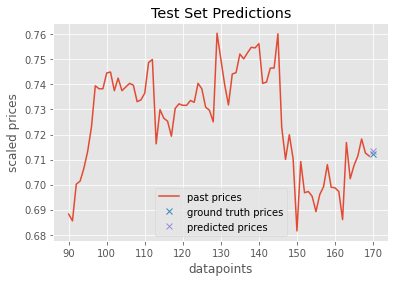

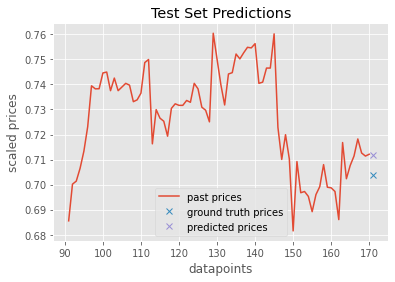

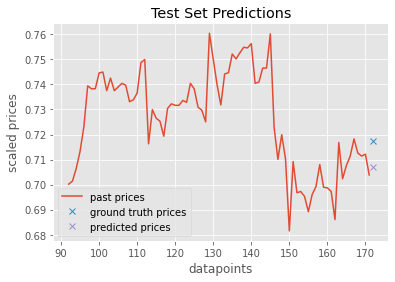

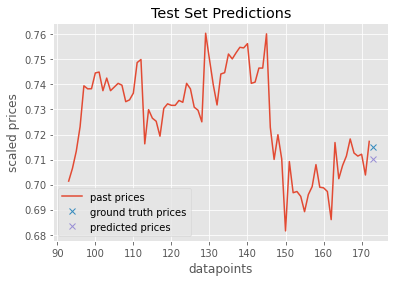

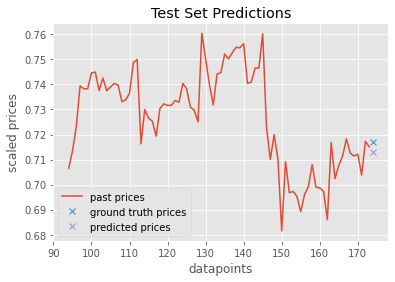

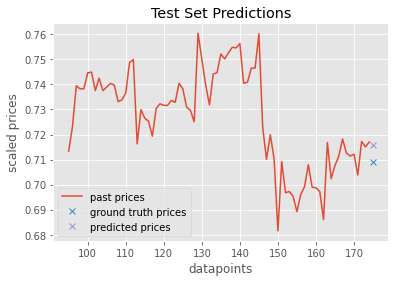

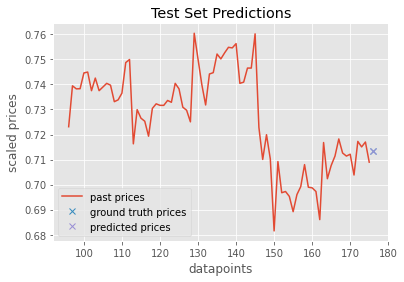

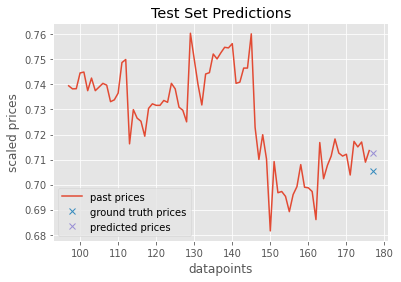

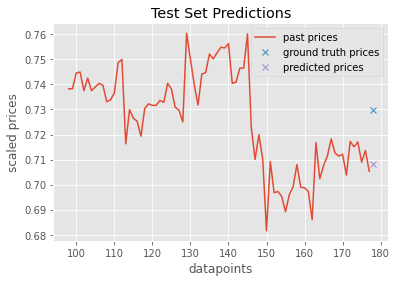

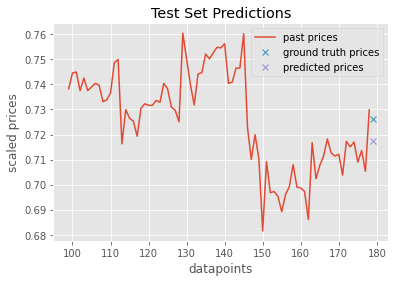

In [70]:
#graph closer look within batches
#To be completed
def plot_one_batch(batchnumber):
    plt.style.use('ggplot')
    plt.clf()
    plt.plot(x_labels[batchnumber, :], test_X[batchnumber, :], label = "past prices")
    plt.plot(y_labels[batchnumber, :], test_Y[batchnumber, :], 'x',label = "ground truth prices")
    plt.plot(y_labels[batchnumber, :], test_pred[batchnumber, :], 'x',label = "predicted prices")
    plt.title("Test Set Predictions")
    plt.legend()
    plt.xlabel("datapoints")
    plt.ylabel("scaled prices")  
    plt.show()

for i in range(100):
    plot_one_batch(i)